# Cross-sell Investigation
### Product Analytics Exploratory Data Analysis

-----

## 1. Introduction and Aim
We are investigating the cross sell rate between a DNA testing kit and a related platform subscription purchase to identify potential insights. We consider a customer to be a cross sell (from DNA to ACOM subscription) when the following conditions are met in the data:
- xsell_gsa == 1. The customer became a new ACOM subscriber.
- xsell_day_exact <= 120. The customer purchased their ACOM subscription within 120 days of their DNA product order.

#### We will explore the scenarios in which the above conditions are met with the aim to identify opportunities to increase cross sell

In [1]:
# Scientific libraries
import numpy as np
import pandas as pd

# Visual libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px

# Pandas options
pd.set_option('max_colwidth', 40)
pd.options.display.max_columns = None
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## 2. Basic Exploration And Preprocessing

In [2]:
df = pd.read_csv(*redacted*)

In [3]:
df.info()
df.describe()
# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251942 entries, 0 to 251941
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               251942 non-null  int64  
 1   prospectid               251942 non-null  int64  
 2   ordernumber              251942 non-null  int64  
 3   ordercreatedate          251942 non-null  object 
 4   regtenure                251942 non-null  object 
 5   customer_type_group      251942 non-null  object 
 6   dnatestactivationdayid   178845 non-null  object 
 7   daystogetresult_grp      251942 non-null  object 
 8   dna_visittrafficsubtype  189093 non-null  object 
 9   xsell_gsa                251942 non-null  int64  
 10  xsell_day_exact          40579 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 21.1+ MB


,Unnamed: 0,prospectid,ordernumber,xsell_gsa,xsell_day_exact
count,251942.000000,2.519420e+05,2.519420e+05,251942.000000,40579.000000
mean,125971.500000,1.144561e+08,1.455821e+08,0.161065,140.674043
std,72729.535098,5.277515e+07,1.752503e+07,0.367591,668.588251
min,1.000000,7.600000e+02,9.592366e+07,0.000000,0.000000
25%,62986.250000,7.189144e+07,1.356459e+08,0.000000,0.000000
50%,125971.500000,1.243254e+08,1.504135e+08,0.000000,22.000000
75%,188956.750000,1.649072e+08,1.599612e+08,0.000000,100.000000
max,251942.000000,1.795105e+08,1.667366e+08,1.000000,42302.000000


Unnamed: 0                      0
prospectid                      0
ordernumber                     0
ordercreatedate                 0
regtenure                       0
customer_type_group             0
dnatestactivationdayid      73097
daystogetresult_grp             0
dna_visittrafficsubtype     62849
xsell_gsa                       0
xsell_day_exact            211363
dtype: int64

### Issues List for the Dataset:
- Missing values in columns: dnatestactivationdayid, dna_visittrafficsubtype, xsell_day_exact
    - No need to remove these rows as they provide important context data
- All columns not in snake_case
- Need to drop the redundant column Unnamed: 0
- Need an easy way to determine if a customer is a cross sell

In [4]:
# Fixing the above issues:
df.drop(columns=['Unnamed: 0'], inplace=True)

#appropriate column names
new_col_names = ["prospect_id", "order_number", "order_created_date", "reg_tenure_days", "customer_type_group", 
                 "test_activation_date", "weeks_to_result_group", "dna_visit_traffic_type", "xsell_gsa", "xsell_day_exact"]
df.columns = new_col_names

# Define a function to determine if a customer has cross-sold
def is_cross_sell(row):
    if row['xsell_gsa'] == 1 and row['xsell_day_exact'] <= 120:
        return 1
    else:
        return 0

# Create a new column indicating whether a customer has cross-sold
df['is_cross_sell'] = df.apply(is_cross_sell, axis=1)

In [5]:
# New, clean dataframe head
print(df.head())

   prospect_id  order_number order_created_date         reg_tenure_days  \
0     93771712     127707306         2014-11-28  More than 120 days old   
1    123112555     114401425         2013-12-05      Order prior to reg   
2    171965960     159656050         2016-11-25      Order prior to reg   
3    175522116     165370285         2017-03-08               <=60 days   
4    149288086     132837125         2015-03-30      Order prior to reg   

  customer_type_group test_activation_date weeks_to_result_group  \
0        Existing Reg           2014-12-10               4 weeks   
1             New Reg           2014-01-13               4 weeks   
2             New Reg                  NaN                    -1   
3        Existing Reg                  NaN                    -1   
4             New Reg           2015-04-06               4 weeks   

  dna_visit_traffic_type  xsell_gsa  xsell_day_exact  is_cross_sell  
0                    NaN          1             38.0              1  


## 3. Analysis and Visualizations

### The fraction of observed customers who cross-sell from DNA to ACOM subscription is 12.4%

In [6]:
num_customers_with_xsell = df[(df['xsell_gsa'] == 1) & (df['xsell_day_exact'] <= 120)].shape[0]
total_num_customers = df.shape[0]
fraction_cross_sell = num_customers_with_xsell / total_num_customers

fraction_cross_sell

0.12390153289249113

### Existing Registered Customers have the highest cross-sell rate

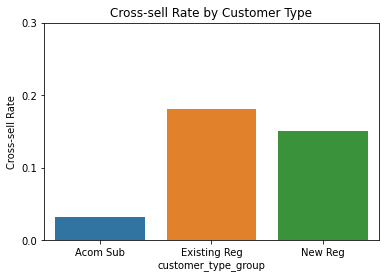

In [21]:
# Calculate the cross-sell rate for each customer group
cross_sell_rate = df[(df['is_cross_sell'] == 1)]['prospect_id'].groupby(df['customer_type_group']).count() / df['prospect_id'].groupby(df['customer_type_group']).count()

# Create a bar chart using Seaborn
sns.barplot(x=cross_sell_rate.index, y=cross_sell_rate.values);

# Set the y-axis limits to go up to 0.3
plt.ylim(0, 0.3);

plt.yticks(np.arange(0, 0.31, 0.1));
plt.ylabel("Cross-sell Rate");
plt.title("Cross-sell Rate by Customer Type");

### Most Cross Sellers get the ACOM Subscription about one week after the DNA Product Purchase. There is also a second peak about a month out

This is determined by looking at the distribution of the number of days between the DNA product purchase and the ACOM subscription purchase for customers who did cross-sell. This will help us understand how long it typically takes for customers to make the transition from DNA product to subscription.

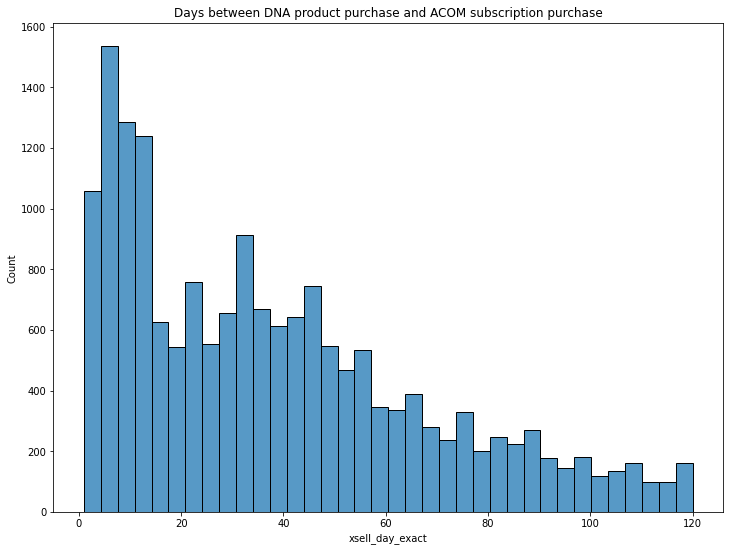

In [28]:
#finding and removing clear outliers
q_low = df["xsell_day_exact"].quantile(0.01)
q_hi  = df["xsell_day_exact"].quantile(0.99)

df2 = df[(df["xsell_day_exact"] < q_hi) & (df["xsell_day_exact"] > q_low)]

# Plot the distribution of days between DNA product purchase and ACOM subscription purchase for
#customers who cross-sell using Seaborn

plt.figure(figsize=(12, 9));
sns.histplot(data=df2[df2['is_cross_sell'] == 1], x='xsell_day_exact');

plt.title("Days between DNA product purchase and ACOM subscription purchase");

### The number of days taken for the DNA test results to be ready doesn't appear to affect the proportion of those that cross sell

We will look at the relationship between the number of days taken for the DNA test results to be ready and the likelihood of cross-selling. This may be relevant because customers who receive their results faster may be more likely to be interested in continuing their family history research through an ACOM subscription.

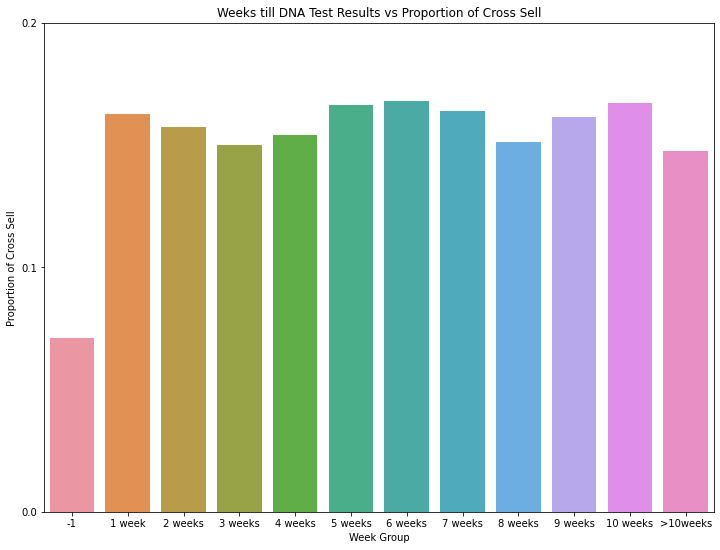

In [29]:
# Group the data by the daystogetresult_grp column
grouped_df = df.groupby('weeks_to_result_group')

# Calculate the proportion of 1s in the is_cross_sell column for each group
result = grouped_df['is_cross_sell'].apply(lambda x: x.value_counts(normalize=True)[1])

result1 = result.to_frame(name="percentage that cross sell")

result1 = result1.reset_index()
result1 = result1.rename(columns={"weeks_to_result_group": "Week Group"})

#create a new column with the order of the week groups
result1['Week Group Order'] = result1['Week Group'].apply(lambda x: int(x.split()[0]) if '>' not in x else 11)

#sort the dataframe by the Week Group Order column
result1 = result1.sort_values(by='Week Group Order')

plt.figure(figsize=(12, 9));

sns.barplot(x='Week Group', y='percentage that cross sell', data=result1);

plt.ylim(0, 0.2);

plt.yticks(np.arange(0, 0.21, 0.1));
plt.ylabel("Proportion of Cross Sell");
plt.title("Weeks till DNA Test Results vs Proportion of Cross Sell");

### FTM Software Integration could be the key to greater Cross Sell

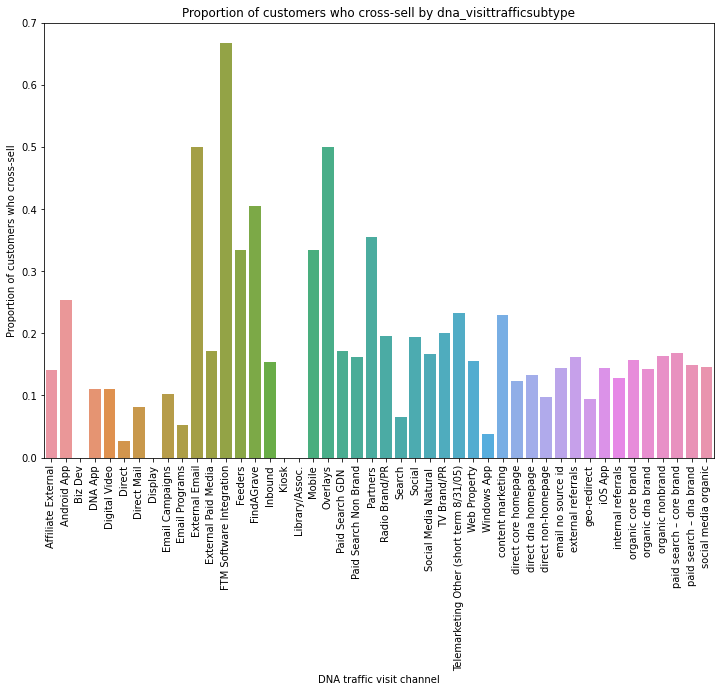

In [12]:
# Calculate the proportion of customers who cross-sell for each value in the dna_visittrafficsubtype column
proportion_xsell = df.groupby('dna_visit_traffic_type')['is_cross_sell'].mean()

# Create a bar plot showing the proportion of customers who cross-sell for each value in the dna_visittrafficsubtype column
plt.figure(figsize=(12, 8));
sns.barplot(x=proportion_xsell.index, y=proportion_xsell.values);
plt.xlabel('DNA traffic visit channel');
plt.ylabel('Proportion of customers who cross-sell');
plt.title('Proportion of customers who cross-sell by dna_visittrafficsubtype');
plt.xticks(rotation=90);
plt.show();


## 4. Conclusion of EDA

----

###  The fraction of observed customers who cross-sell from DNA to ACOM subscription is 12.4%
The variation of this fraction over time can serve as an indicator of how successful efforts to increase cross sell might be.

### Existing Registered Customers have the highest cross-sell rate
This is something worth investigating further. Perhaps we may consider surveying this subgroup or sending targetted ads.

### Most Cross Sellers get the ACOM Subscription about one week after the DNA Product Purchase. There is also a second spike about a month out
This is also worth investigating further, the interesting spikes almost exactly a week and a month after the purchase may imply that scheduled marketing emails may be working well.

### The number of days taken for the DNA test results to be ready doesn't appear to affect the proportion of those that cross sell
This allows us to potentially disregard the number of days taken for the DNA test results to be ready  as an influence on cross sell.
### FTM Software Integration could be the key to greater cross sell
Perhaps we should seek wider FTM Software integration or focus more resources on this tactic to increase cross sell.